<a href="https://colab.research.google.com/github/Pranav-Raj-05/43611105/blob/main/DrugDiscovery_RD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 56.8 MB/s eta 0:00:00


In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv \
    -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
!pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.2 MB/s eta 0:00:00


Device: cuda

Loading QM9 dataset (multi-target regression)...
Analyzing and scaling a single target property...
Focusing on a single property: 'μ (dipole moment)'
Original targets range: 0.0000 to 29.5564
Scaled targets range: -1.7779 to 17.8809

Verification - first 3 samples:
Original: 0.000 -> Scaled: -1.778
Original: 1.626 -> Scaled: -0.697
Original: 1.851 -> Scaled: -0.547

Shuffling and splitting dataset...

DATA INTEGRITY DEBUGGING - TARGET VALUES
First 5 training samples - TARGET VALUES:
Sample 0: y = tensor([[0.3175]]) (shape: torch.Size([1, 1]))
  Value: 0.3174962103366852
Sample 1: y = tensor([[-1.0297]]) (shape: torch.Size([1, 1]))
  Value: -1.0297174453735352
Sample 2: y = tensor([[0.9164]]) (shape: torch.Size([1, 1]))
  Value: 0.9163761138916016
Sample 3: y = tensor([[-0.8076]]) (shape: torch.Size([1, 1]))
  Value: -0.8076317310333252
Sample 4: y = tensor([[0.6010]]) (shape: torch.Size([1, 1]))
  Value: 0.6009730100631714


/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)



Training targets statistics:
Min: -1.7779, Max: 12.0879
Mean: -0.0005, Std: 1.0093
(Values should be close to Mean=0, Std=1)


Loading MUTAG dataset (classification)...


Processing...
Done!



Starting Drug Discovery Model Training...
QM9: Predicting 1 Molecular Property
MUTAG: Toxicity (Mutagenicity) Classification
Epoch 01 | Mol. Property - Loss 0.2667 | Val MAE (scaled) 0.5455 | Val R² 0.4130
         | Toxicity Pred. - Loss 0.6479 | Val Acc 0.6316
Epoch 05 | Mol. Property - Loss 0.2090 | Val MAE (scaled) 0.4881 | Val R² 0.4978
         | Toxicity Pred. - Loss 0.4754 | Val Acc 0.7368
Epoch 10 | Mol. Property - Loss 0.1939 | Val MAE (scaled) 0.4869 | Val R² 0.5099
         | Toxicity Pred. - Loss 0.4447 | Val Acc 0.7368
Epoch 15 | Mol. Property - Loss 0.1854 | Val MAE (scaled) 0.4568 | Val R² 0.5625
         | Toxicity Pred. - Loss 0.4491 | Val Acc 0.7368
Epoch 20 | Mol. Property - Loss 0.1762 | Val MAE (scaled) 0.4493 | Val R² 0.5734
         | Toxicity Pred. - Loss 0.4223 | Val Acc 0.7368
Epoch 25 | Mol. Property - Loss 0.1693 | Val MAE (scaled) 0.4411 | Val R² 0.6077
         | Toxicity Pred. - Loss 0.4212 | Val Acc 0.7368
Epoch 30 | Mol. Property - Loss 0.1644 | Val M

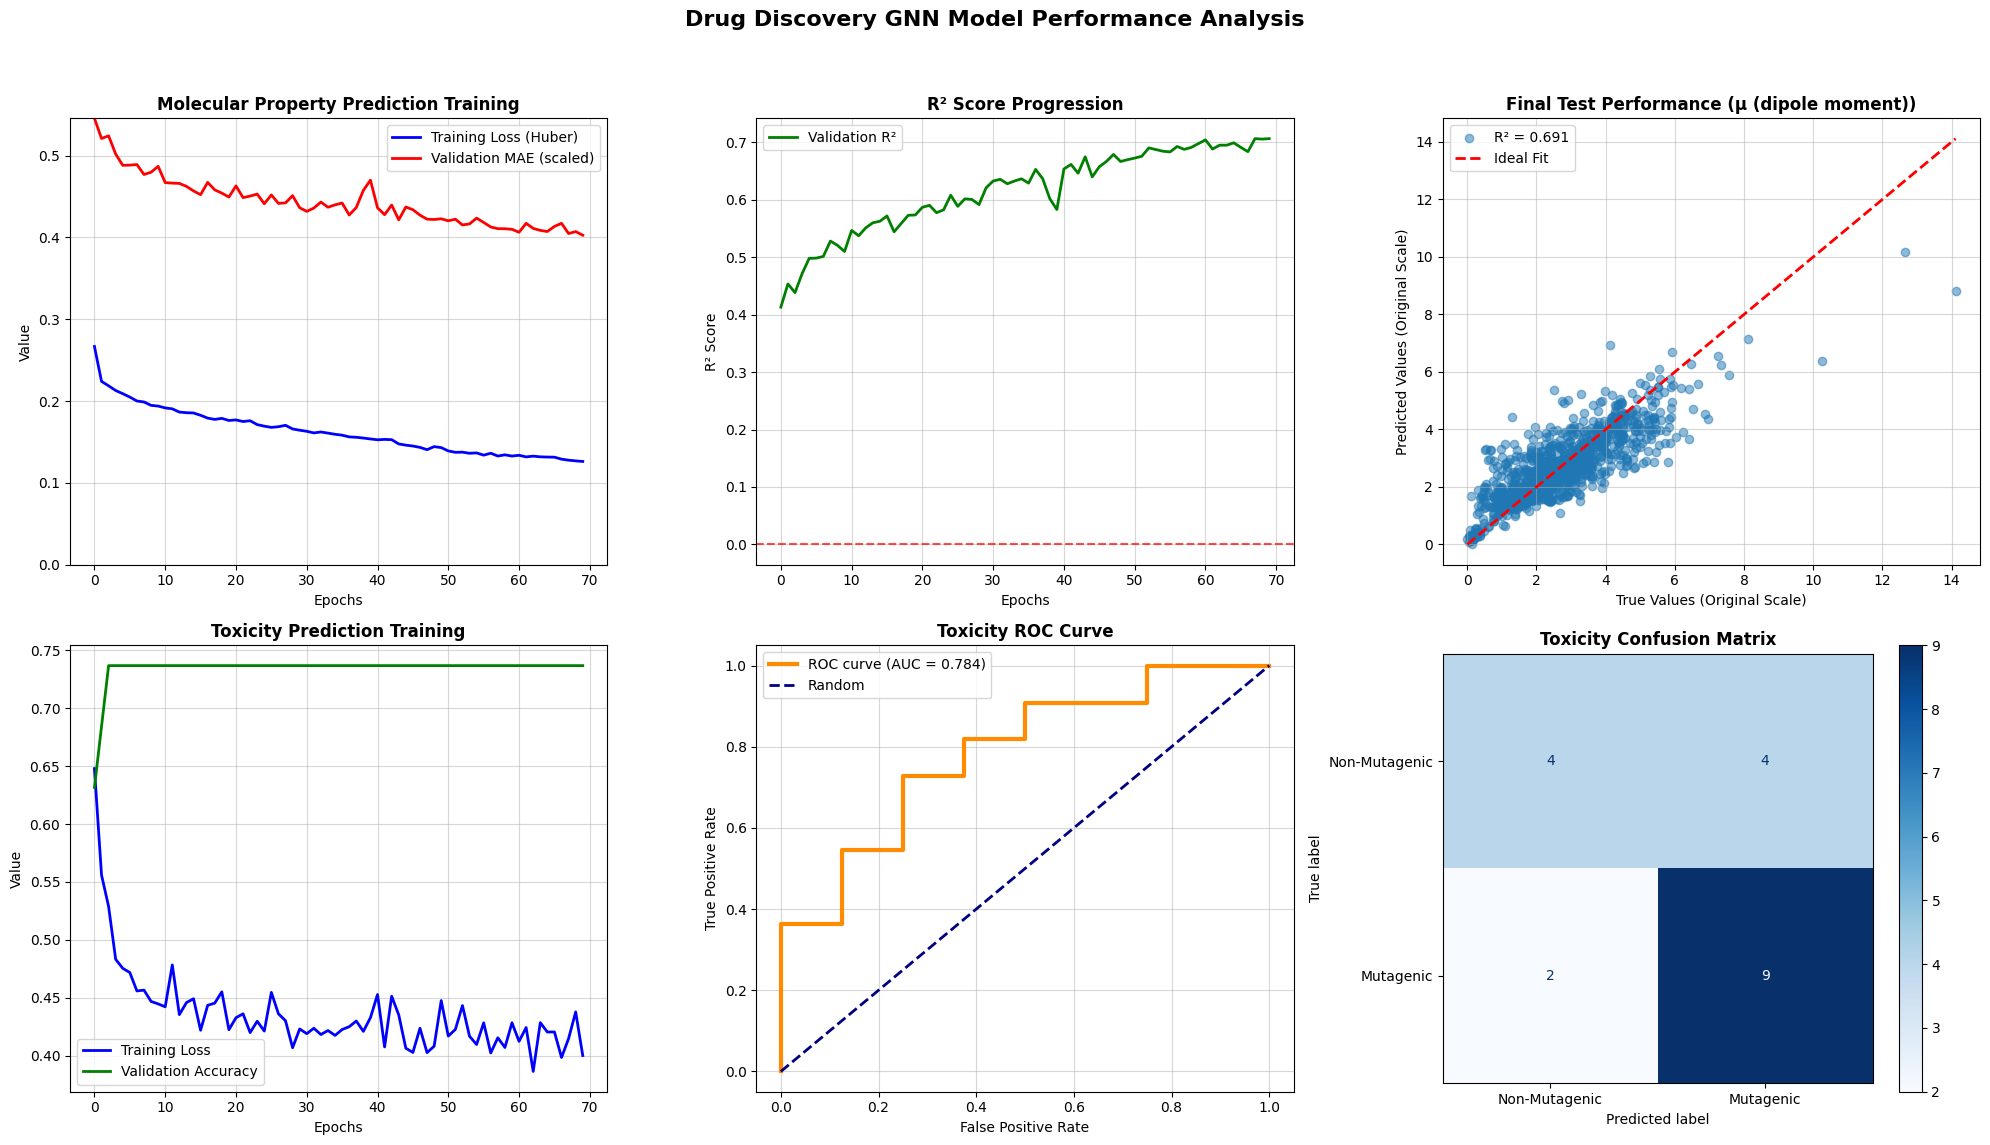

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import QM9, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphNorm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

print("\nLoading QM9 dataset (multi-target regression)...")
dataset = QM9(root="data/QM9")

print("Analyzing and scaling a single target property...")
property_names = [
    'μ (dipole moment)', 'α (polarizability)', 'HOMO', 'LUMO', 'HOMO-LUMO gap',
    'R² (electronic extent)', 'ZPVE', 'U₀ (internal energy)', 'U (internal energy)',
    'H (enthalpy)', 'G (free energy)', 'Cv (heat capacity)',
    'U₀ atomization', 'U atomization', 'H atomization', 'G atomization',
    'A (rot. const. A)', 'B (rot. const. B)', 'C (rot. const. C)'
]

target_idx = 0
print(f"Focusing on a single property: '{property_names[target_idx]}'")

all_original_targets = dataset.data.y[:, target_idx].clone().numpy()
print(f"Original targets range: {all_original_targets.min():.4f} to {all_original_targets.max():.4f}")

scaler = StandardScaler()

scaled_targets = scaler.fit_transform(all_original_targets.reshape(-1, 1))
print(f"Scaled targets range: {scaled_targets.min():.4f} to {scaled_targets.max():.4f}")

dataset.data.y = torch.tensor(scaled_targets, dtype=torch.float32)

dataset._data_list = None

print("\nVerification - first 3 samples:")
for i in range(3):
    print(f"Original: {all_original_targets[i]:.3f} -> Scaled: {dataset[i].y.item():.3f}")

print("\nShuffling and splitting dataset...")
dataset = dataset.shuffle()

train_dataset_reg = dataset[:10000]
val_dataset_reg = dataset[10000:11000]
test_dataset_reg = dataset[11000:12000]

print("\n" + "="*60)
print("DATA INTEGRITY DEBUGGING - TARGET VALUES")
print("="*60)

print("First 5 training samples - TARGET VALUES:")
for i, data in enumerate(train_dataset_reg[:5]):
    print(f"Sample {i}: y = {data.y} (shape: {data.y.shape})")
    print(f"  Value: {data.y.item()}")

all_train_targets = np.array([data.y.item() for data in train_dataset_reg])
print(f"\nTraining targets statistics:")
print(f"Min: {all_train_targets.min():.4f}, Max: {all_train_targets.max():.4f}")
print(f"Mean: {all_train_targets.mean():.4f}, Std: {all_train_targets.std():.4f}")
print("(Values should be close to Mean=0, Std=1)")
print("="*60 + "\n")

train_loader_reg = DataLoader(train_dataset_reg, batch_size=64, shuffle=True)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=64)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=64)

print("\nLoading MUTAG dataset (classification)...")
mutag = TUDataset(root="data/MUTAG", name="MUTAG")
torch.manual_seed(42)
mutag = mutag.shuffle()
split1 = int(0.8 * len(mutag))
split2 = int(0.9 * len(mutag))
train_dataset_c, val_dataset_c, test_dataset_c = mutag[:split1], mutag[split1:split2], mutag[split2:]

train_loader_c = DataLoader(train_dataset_c, batch_size=32, shuffle=True)
val_loader_c = DataLoader(val_dataset_c, batch_size=32)
test_loader_c = DataLoader(test_dataset_c, batch_size=32)

class GCNReg(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.25):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.norm2 = GraphNorm(hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)

        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.lin2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(self.norm1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.norm2(x))
        x = self.conv3(x, edge_index)
        x = F.relu(self.norm3(x))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

class GCNClf(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.lin1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.dropout = nn.Dropout(dropout)
        self.lin2 = nn.Linear(hidden_dim // 2, out_dim)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(self.norm1(x))
        x = self.conv2(x, edge_index)
        x = F.relu(self.norm2(x))
        x = self.conv3(x, edge_index)
        x = F.relu(self.norm3(x))
        x = global_mean_pool(x, batch)
        x = F.relu(self.lin1(x))
        x = self.dropout(x)
        return self.lin2(x)

def train_epoch(loader, model, optimizer, loss_fn, is_regression=False):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        target = data.y.view_as(out) if is_regression else data.y
        loss = loss_fn(out, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_reg(loader, model):
    model.eval()
    y_true_scaled_list, y_pred_scaled_list = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            y_true_scaled_list.append(data.y.cpu())
            y_pred_scaled_list.append(out.cpu())

    y_true_scaled = torch.cat(y_true_scaled_list).numpy()
    y_pred_scaled = torch.cat(y_pred_scaled_list).numpy()
    scaled_mae = mean_absolute_error(y_true_scaled, y_pred_scaled)

    y_true_orig = scaler.inverse_transform(y_true_scaled)
    y_pred_orig = scaler.inverse_transform(y_pred_scaled)
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    return mae_orig, scaled_mae, r2, y_true_orig, y_pred_orig

def eval_clf(loader, model):
    model.eval()
    ys, preds, outs = [], [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            ys.append(data.y.cpu())
            preds.append(pred.cpu())
            outs.append(out.cpu())
    y_true = torch.cat(ys).numpy()
    y_pred = torch.cat(preds).numpy()
    y_scores = F.softmax(torch.cat(outs), dim=1)[:, 1].numpy()
    acc = (y_true == y_pred).mean()
    return acc, y_true, y_pred, y_scores

hidden_dim = 128

model_reg = GCNReg(in_dim=dataset.num_node_features,
                   hidden_dim=hidden_dim,
                   out_dim=1).to(device)

model_clf = GCNClf(in_dim=mutag.num_node_features,
                   hidden_dim=hidden_dim,
                   out_dim=mutag.num_classes).to(device)

opt_reg = torch.optim.Adam(model_reg.parameters(), lr=5e-4, weight_decay=1e-5)
opt_clf = torch.optim.Adam(model_clf.parameters(), lr=0.001, weight_decay=1e-5)

loss_reg_fn = nn.HuberLoss()
loss_clf_fn = nn.CrossEntropyLoss()

scheduler_reg = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_reg, 'min', patience=5, factor=0.7)
scheduler_clf = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_clf, 'max', patience=5, factor=0.5)

epochs = 70
history_reg = {'loss': [], 'val_mae': [], 'val_mae_scaled': [], 'val_r2': []}
history_clf = {'loss': [], 'val_acc': []}

print("\nStarting Drug Discovery Model Training...")
print(f"QM9: Predicting 1 Molecular Property")
print("MUTAG: Toxicity (Mutagenicity) Classification")
print("=" * 60)

for epoch in range(1, epochs+1):
    tr_loss_reg = train_epoch(train_loader_reg, model_reg, opt_reg, loss_reg_fn, is_regression=True)
    val_mae, val_mae_scaled, val_r2, _, _ = eval_reg(val_loader_reg, model_reg)
    scheduler_reg.step(val_mae_scaled)
    history_reg['loss'].append(tr_loss_reg)
    history_reg['val_mae'].append(val_mae)
    history_reg['val_mae_scaled'].append(val_mae_scaled)
    history_reg['val_r2'].append(val_r2)

    tr_loss_clf = train_epoch(train_loader_c, model_clf, opt_clf, loss_clf_fn)
    val_acc, _, _, _ = eval_clf(val_loader_c, model_clf)
    scheduler_clf.step(val_acc)
    history_clf['loss'].append(tr_loss_clf)
    history_clf['val_acc'].append(val_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Mol. Property - Loss {tr_loss_reg:.4f} | Val MAE (scaled) {val_mae_scaled:.4f} | Val R² {val_r2:.4f}")
        print(f"         | Toxicity Pred. - Loss {tr_loss_clf:.4f} | Val Acc {val_acc:.4f}")

test_mae, test_mae_scaled, test_r2, y_true_reg, y_pred_reg = eval_reg(test_loader_reg, model_reg)
test_acc, y_true_clf, y_pred_clf, y_scores_clf = eval_clf(test_loader_c, model_clf)

print("\n" + "="*60)
print("FINAL DRUG DISCOVERY MODEL EVALUATION")
print("="*60)
print(f"MOLECULAR PROPERTY PREDICTION ({property_names[target_idx]}):")
print(f"Overall MAE (Original Scale): {test_mae:.4f}")
print(f"Overall MAE (Scaled Target): {test_mae_scaled:.4f}")
print(f"Overall R²: {test_r2:.4f}")

print("\nTOXICITY PREDICTION (MUTAG):")
print(f"Accuracy: {test_acc:.4f}")

fig = plt.figure(figsize=(20, 12))
fig.suptitle('Drug Discovery GNN Model Performance Analysis', fontsize=16, fontweight='bold')
gs = fig.add_gridspec(2, 3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history_reg['loss'], 'b-', label='Training Loss (Huber)', linewidth=2)
ax1.plot(history_reg['val_mae_scaled'], 'r-', label='Validation MAE (scaled)', linewidth=2)
ax1.set_title('Molecular Property Prediction Training', fontweight='bold')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Value'); ax1.legend(); ax1.grid(True, alpha=0.5)
ax1.set_ylim(bottom=0, top=min(2.0, max(history_reg['val_mae_scaled'] if history_reg['val_mae_scaled'] else [2.0])))

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history_reg['val_r2'], 'g-', label='Validation R²', linewidth=2)
ax2.set_title('R² Score Progression', fontweight='bold')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('R² Score'); ax2.legend(); ax2.grid(True, alpha=0.5)
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.7)

ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_true_reg, y_pred_reg, alpha=0.5, label=f'R² = {test_r2:.3f}')
ax3.plot([y_true_reg.min(), y_true_reg.max()], [y_true_reg.min(), y_true_reg.max()], 'r--', lw=2, label='Ideal Fit')
ax3.set_title(f'Final Test Performance ({property_names[target_idx]})', fontweight='bold')
ax3.set_xlabel('True Values (Original Scale)'); ax3.set_ylabel('Predicted Values (Original Scale)')
ax3.grid(True, alpha=0.5)
ax3.legend()

ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(history_clf['loss'], 'b-', label='Training Loss', linewidth=2)
ax4.plot(history_clf['val_acc'], 'g-', label='Validation Accuracy', linewidth=2)
ax4.set_title('Toxicity Prediction Training', fontweight='bold')
ax4.set_xlabel('Epochs'); ax4.set_ylabel('Value'); ax4.legend(); ax4.grid(True, alpha=0.5)

ax5 = fig.add_subplot(gs[1, 1])
fpr, tpr, _ = roc_curve(y_true_clf, y_scores_clf)
roc_auc = auc(fpr, tpr)
ax5.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.3f})')
ax5.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Random')
ax5.set_title('Toxicity ROC Curve', fontweight='bold')
ax5.set_xlabel('False Positive Rate'); ax5.set_ylabel('True Positive Rate'); ax5.legend()
ax5.grid(True, alpha=0.5)
x
ax6 = fig.add_subplot(gs[1, 2])
cm = confusion_matrix(y_true_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(cm, display_labels=['Non-Mutagenic', 'Mutagenic'])
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax6)
ax6.set_title('Toxicity Confusion Matrix', fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

